In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

Importamos la lista de palabras [LabMT](http://neuro.imm.dtu.dk/wiki/LabMT) para sentiment analysis.

In [3]:
url = 'http://www.plosone.org/article/fetchSingleRepresentation.action?uri=info:doi/10.1371/journal.pone.0026752.s001'
labmt = pd.read_csv(url, skiprows=2, sep='\t', index_col=0) 

In [4]:
average   = labmt.happiness_average.mean()
happiness = (labmt.happiness_average - average).to_dict()

Le decimos a `PlaintextCorpusReader` cómo tiene que segmentar las palabras.

In [11]:
from nltk.corpus import PlaintextCorpusReader

pattern = r'''(?x)    # verbose regexps
      \d+[.:]\d+      # horas y números con decimales
    | mgs?\.          # abreviaturas comunes
    | \w+\.(?:\w+\.)+ # acrónimos
    | \w+             # palabras alfanuméricas
    | [^\w\s]+        # signos de puntuación
'''

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(pattern)

Cargamos un corpus de Erowid.

In [12]:
import os, glob

archivos = [os.path.basename(file) for file in glob.glob('corpus/utf8_*.txt')]
corpus   = PlaintextCorpusReader('corpus', archivos, word_tokenizer=tokenizer)

In [13]:
print('cantidad de experiencias', len(archivos))

cantidad de experiencias 1197


Calculamos la felicidad de las oraciones de cada experiencia.

In [14]:
felicidad_oraciones = {}

for experiencia in archivos:
    s = []
    
    for oración in corpus.sents(experiencia):
        s.append(
            sum([happiness.get(palabra.lower(), 0.0) for palabra in oración]) / len(oración)
        )
        
    felicidad_oraciones[experiencia] = pd.Series(s)

Calculamos la felicidad de cada experiencia promediando la felicidad de sus oraciones.

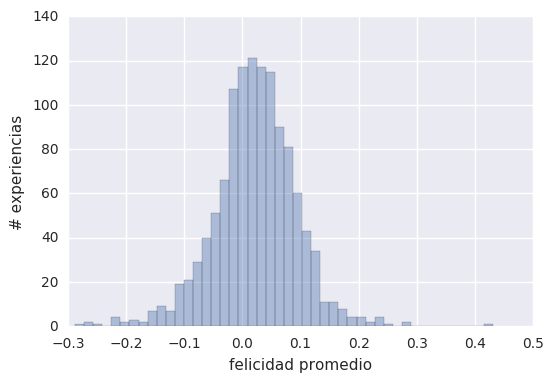

In [15]:
felicidad_experiencias = list(map(np.mean, felicidad_oraciones.values()))
sn.distplot(felicidad_experiencias, kde=False)
plt.ylabel('# experiencias')
plt.xlabel('felicidad promedio');

Queremos calcular la evolución de la felicidad oración a oración. Antes queremos ver cómo se distribuye la longitud de las experiencies medida en cantidad de oraciones; para hacer que las experiencias sean comparables tenemos que normalizar su longitud.

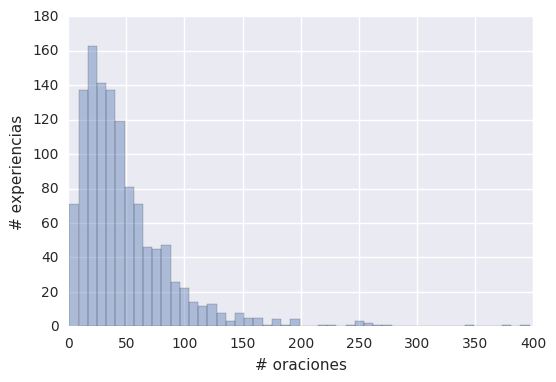

In [16]:
longitud_oraciones = list(map(len, felicidad_oraciones.values()))
sn.distplot(longitud_oraciones, kde=False)
plt.ylabel('# experiencias')
plt.xlabel('# oraciones');

Viendo el histograma, la longitud de las experiencias podría ser 20 oraciones...

In [17]:
LONGITUD = 20

Revisamos algunas experiencias individualmente para entender un poco mejor con qué estamos trabajando.

In [18]:
def analizar_experiencia(experiencia):
    felicidad_oraciones[archivos[experiencia]].plot()
    plt.ylabel('felicidad')
    plt.xlabel('oración')

    for i, oración in enumerate(corpus.sents(archivos[experiencia])):
        print('%2d ' % i, ' '.join(oración))
        
    print('\n\nFELICIDAD', '%.2f' % felicidad_oraciones[archivos[experiencia]].mean())

 0  Well to start off I ' m about 6 ' 1 ' and weigh about 165 lb ' s .
 1  The day started by being boring since my friends were gone .
 2  I decided to go to my local Grocery store and try and find some over - the - counter herbs .
 3  I started by looking at ephedrine .
 4  But I have heard many people die from this drug .
 5  I came across this bottle labeled Kava - Kava Root .
 6  I have heard that it relaxes people and so I went to buy it .
 7  So I went to my home and up to my room .
 8  It was around 11:00 PM and my mom was asleep so I decided this is the best time for it .
 9  But I had to set some things up first .
10  Before I do any kind of drug by myself I have to set up my room properly .
11  I turned on my lava lamp .
12  Then put on my Hypnogenic screensaver .
13  Turned off all the lights and put on my water fountain ( calms me down a lot :)).
14  11:20 PM : I took two capsules .
15  11:50 PM : A slightly calm feeling fell over my body .
16  12:10 PM : I decided to take

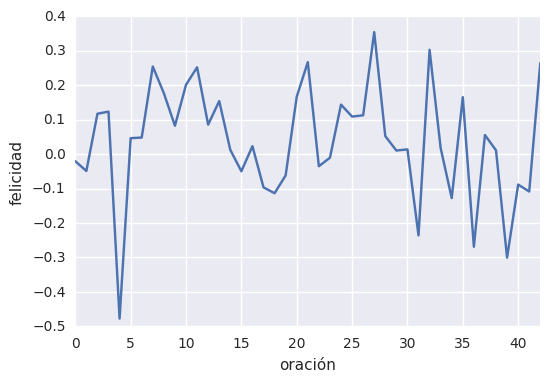

In [19]:
analizar_experiencia(30)

 0  I had tried coke twice before w / no effect , but I ' ll tell you about my third ( and first successful ) experience .
 1  It was only last week actually .
 2  Where I work , mostly people smoke weed , but I found out recently that coke was going around .
 3  After being invited to try it the fist time and then getting some from a friend the second time , I thought that perhaps it just wasn ' t my drug of choice ( pot btw ).
 4  A coworker started to sell it ; so , I thought w / it now being really close by , I would try again .
 5  I bought a 20 bag and waited for a slow period .
 6  When the others were taking a smoke break , I decided to take my break to the car .
 7  I emptied the bag and began to cut it .
 8  Now I went against my normal smart advice and didn ' t do much research about coke .
 9  I know a few people whose drug of choice is coke , but I stupidly didn ' t ask them too much .
10  So , I just separated it into two fat lines .
11  I rolled up a dollar and took them

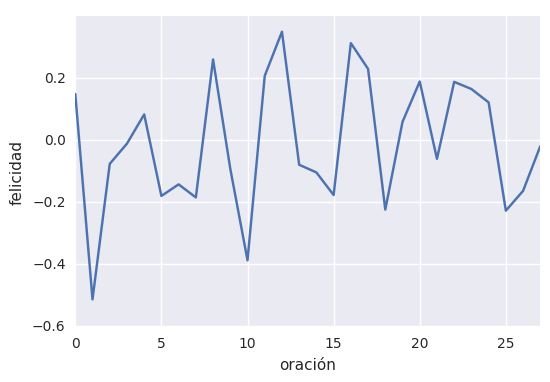

In [20]:
analizar_experiencia(1111)

 0  Meth has become my beautiful white snow , and this is my story , it being both good and bad , of my experiences with methamphetamine .
 1  I am a shift worker , at a gas station , while I work through college .
 2  I don ' t need the job , I like the extra income , and the satisfaction of not relying on my family and friends for my needs .
 3  Shift working is hard .
 4  Hours can be unpredictable at best , and hours are long .
 5  ( I ' ve worked 28 hours straight )
 6  I used ephedra , Xenadrine and other diet drugs to keep me up and working , but I grew very tolerant to it , and I required nearly three times the dose to get the same effects .
 7  Still , when a friend of mine recomended methamphetamine , I didn ' t like the idea , seeing as I live in an area known as ' Felony Flats ', all I ' ve heard are the awful conditions of some meth labs , small children with chemical burns and other sad stories .
 8  I gave in , and tryed a line .
 9  It was amazing .
10  Suddenly , navig

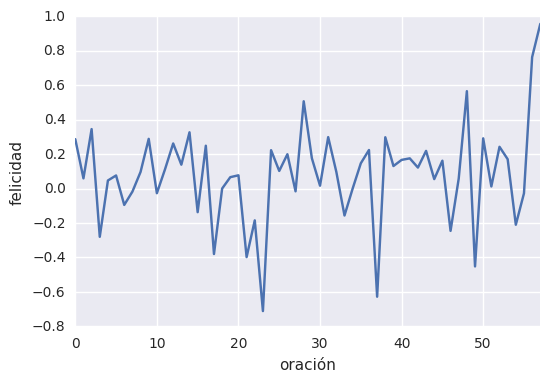

In [21]:
analizar_experiencia(140)

Practicamos una manera de normalizar la extensión de las experiencias y comparamos el antes y el después con algunas. 

In [22]:
def subsample(felicidad_oración, rolling=5):
    suavizado = \
        felicidad_oración \
        .rolling(rolling, center=True).mean() \
        .dropna().reset_index(drop=True)
    
    muestreado = \
        suavizado[ sorted(np.random.choice( range( len(suavizado) ), size=LONGITUD, replace=False)) ] \
        .reset_index(drop=True)
        
    return muestreado

In [23]:
def analizar_subsample(experiencia):
    felicidad_oración = felicidad_oraciones[archivos[experiencia]]
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,3))
    ax1.set_ylim(-0.8,0.8)
    felicidad_oración.plot(ax=ax1)
    subsample(felicidad_oración).plot(ax=ax2);

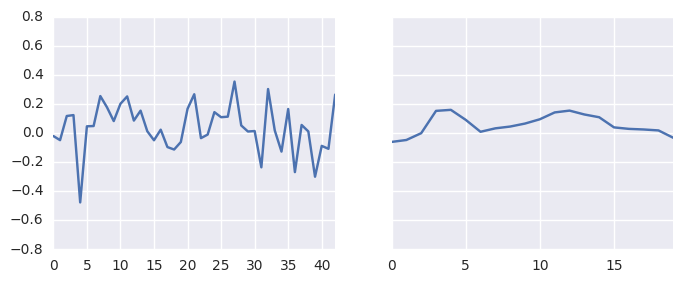

In [54]:
analizar_subsample(30)

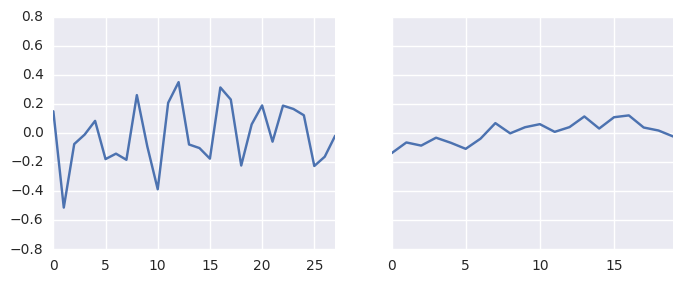

In [62]:
analizar_subsample(1111)

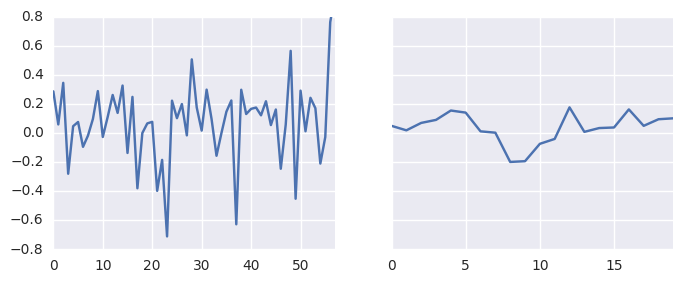

In [71]:
analizar_subsample(140)

Preparamos las muestras para aplicar SVD. Cada columna es una experiencia, cada fila una oración, así podemos reducir la cantidad de experiencias a cierto número reducido de experiencias paradigmáticas.

In [42]:
from sklearn.decomposition import TruncatedSVD

def obtener_arcos(felicidad_oraciones):
    felicidad_oraciones_normalizada = {k:subsample(v) for k,v in felicidad_oraciones.items() if len(v) > LONGITUD + 3}
    felicidad_oraciones_normalizada = pd.DataFrame(felicidad_oraciones_normalizada)

    svd = TruncatedSVD(n_components=6, n_iter=7, random_state=42)
    return pd.DataFrame(svd.fit_transform(felicidad_oraciones_normalizada))

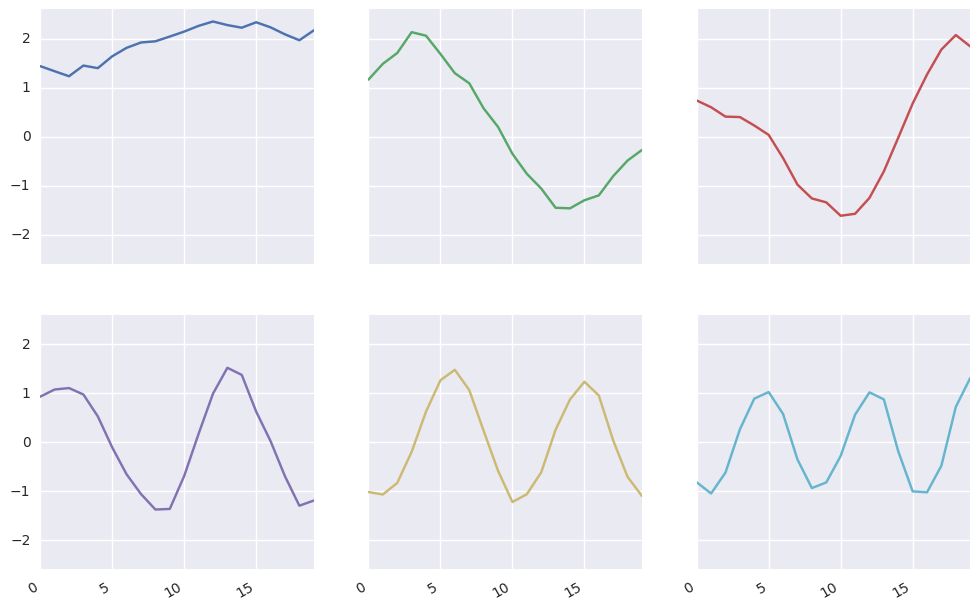

In [43]:
paradigmas = obtener_arcos(felicidad_oraciones)
paradigmas.plot(subplots=True, layout=(2,3), sharey=True, ylim=(-2.6,2.6), figsize=(12,8), legend=False);

21/04/2018

Se está tokenizando didn't y otras abreviaciones como didn + t. Esto no está mal para LSA pero quizás sí afecte a SA.

http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization

---

In [5]:
import re

In [14]:
import pandas as pd
df = pd.read_csv('corpus.json').assign(droga=lambda x: x.droga.str.replace('_', ' ')).set_index(['droga', 'experiencia', 'posición'])

In [15]:
df['felicidad'] = df.palabra.apply(happiness.get).fillna(0)

Observamos que LabMT tiene preconceptos acerca de las drogas.

In [11]:
for droga in erowid.droga.unique():
    h = happiness.get(re.sub('_', ' ', droga.lower()))
    
    if h:
        print("{}\t{: .2f}".format(droga, h))

Alcohol	-0.18
Cocaine	-2.84
DOC	-0.34
Crack	-1.66
DOM	-0.46
Coffee	 1.80


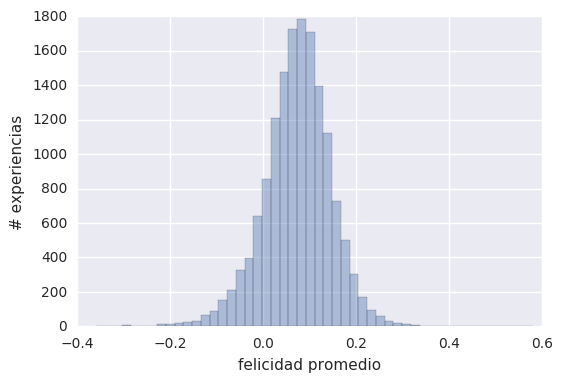

In [12]:
sn.distplot(df.groupby('experiencia').felicidad.mean(), kde=False)
plt.ylabel('# experiencias')
plt.xlabel('felicidad promedio');

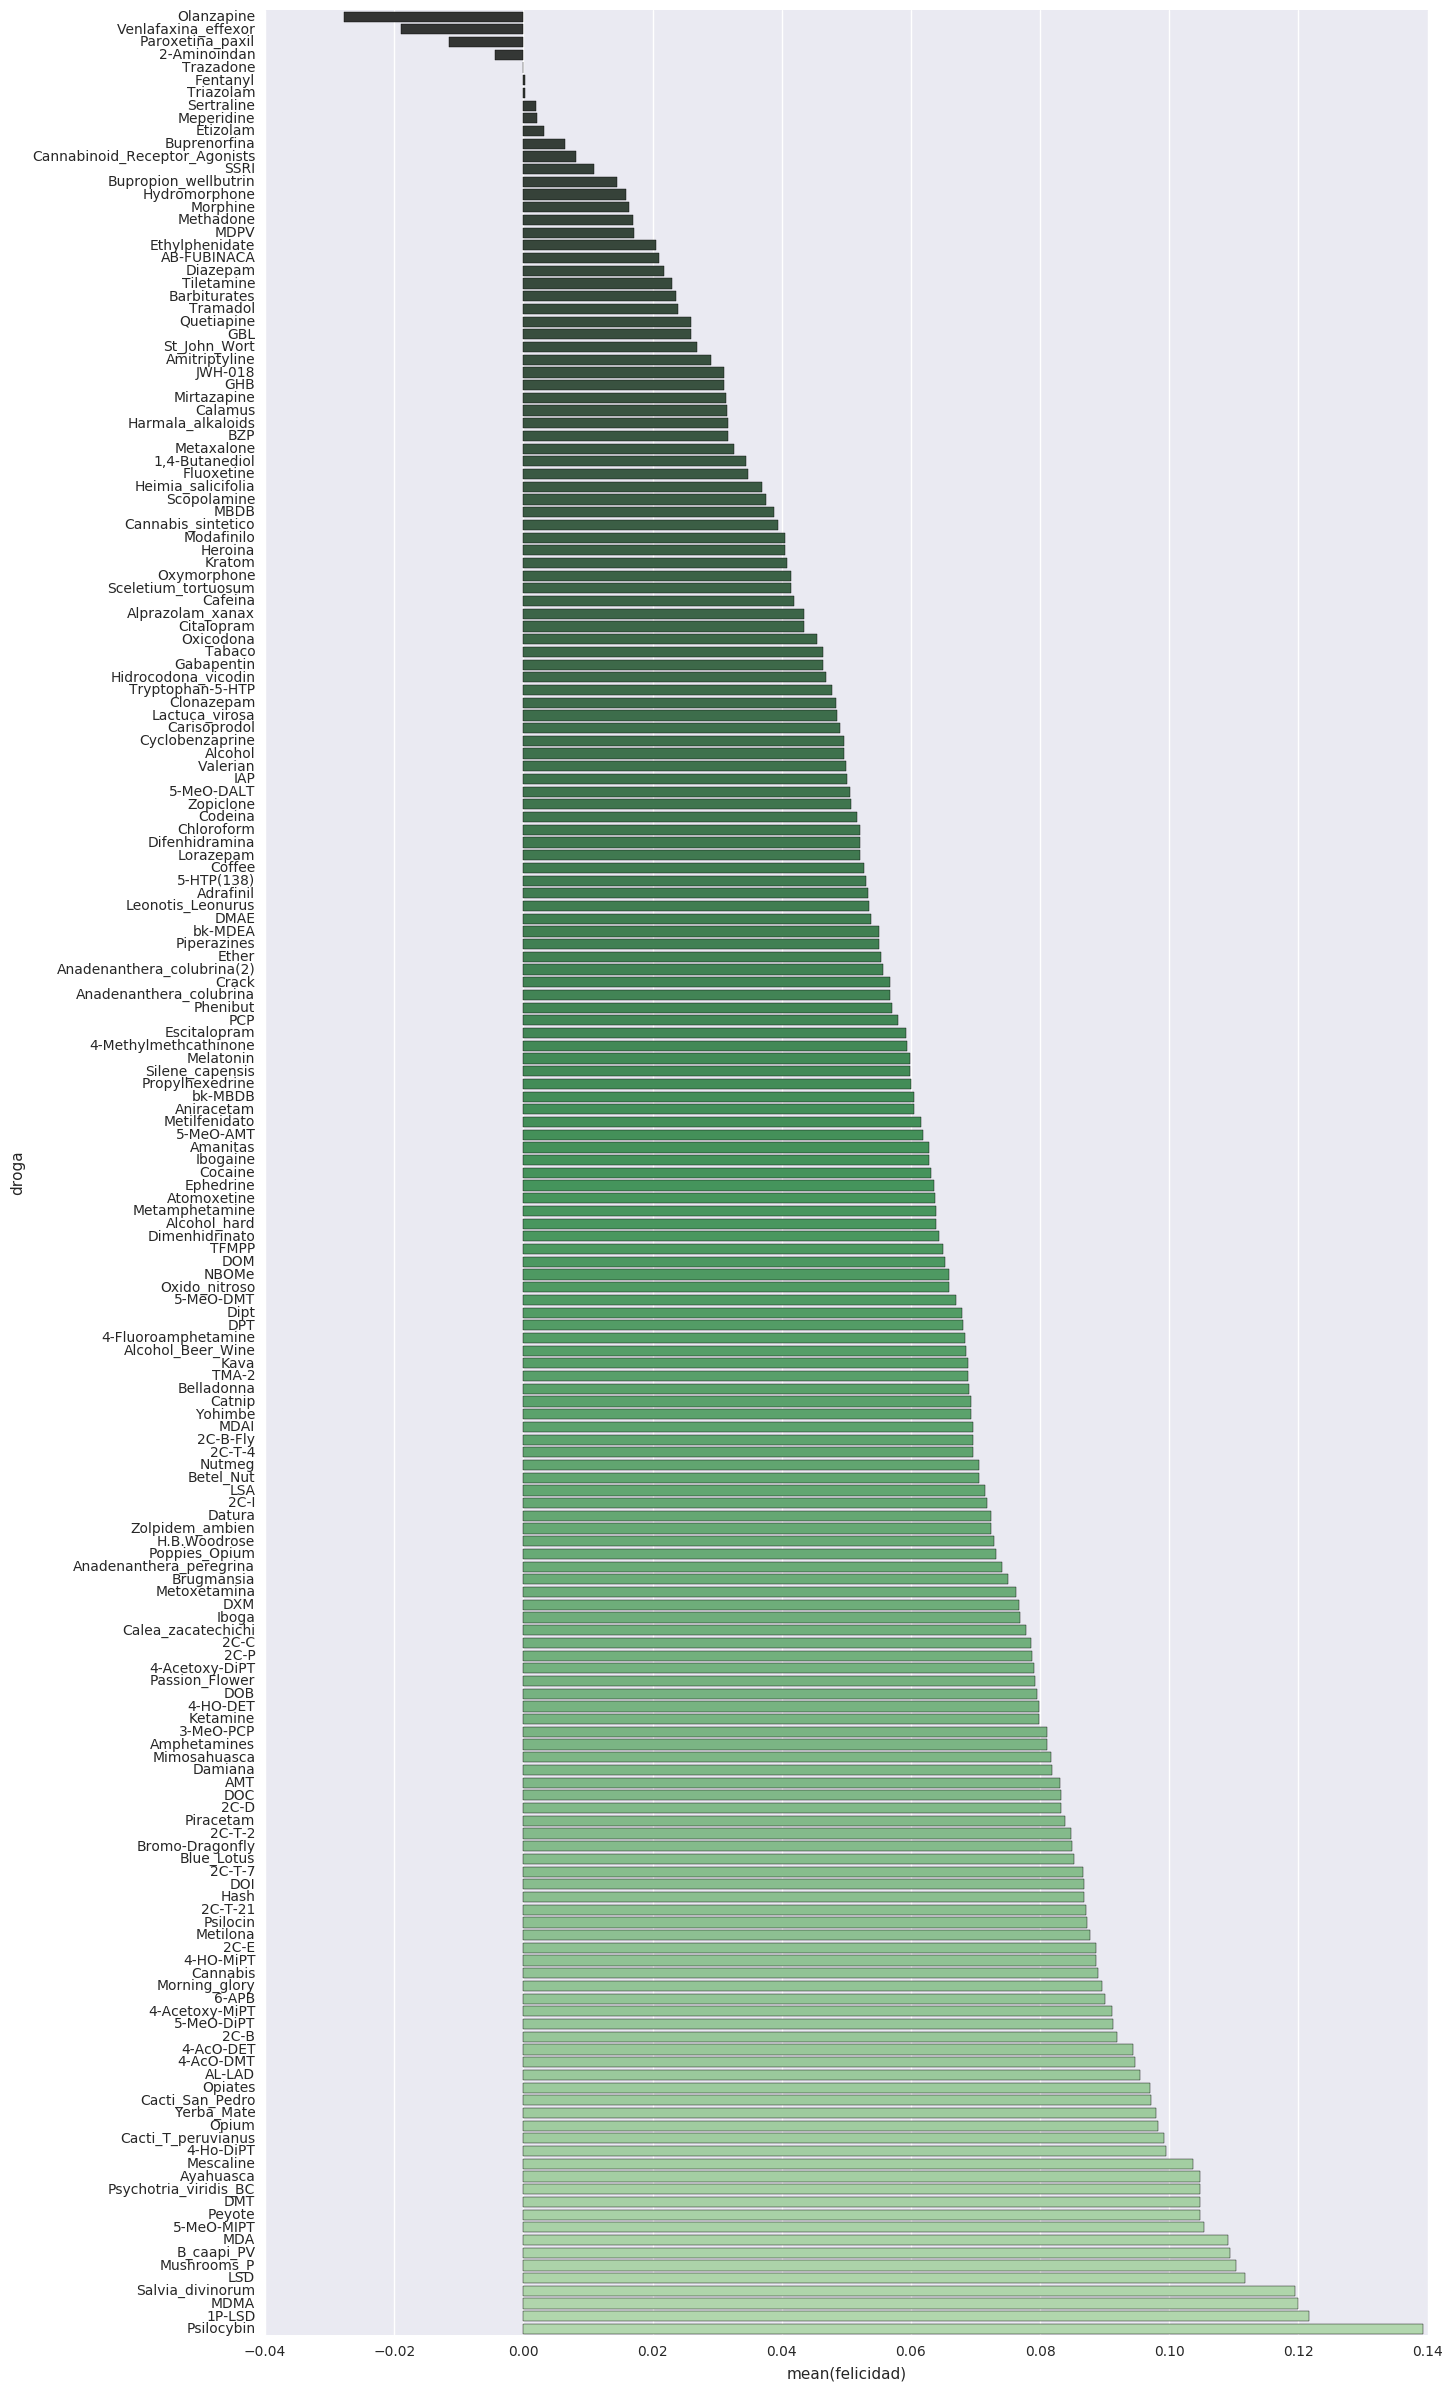

In [16]:
felicidad_droga = df.groupby('droga').felicidad.mean().to_frame().reset_index().sort_values('felicidad')

fig, ax = plt.subplots(figsize=(15,30))
sn.barplot(ax=ax, data=felicidad_droga, y='droga', x='felicidad', palette="Greens_d");

In [8]:
categorías = {
    1 : 'Psychedelic (other)',
    2 : 'Psychedelic (serotonergic)',
    3 : 'Psychedelic (entactogen)',
    4 : 'Psychedelic (dissociative)',
    5 : 'Depressant/sedative',
    6 : 'Stimulant',
    7 : 'Delirant',
    8 : 'MAOI',
    9 : 'Antipsychotic/antidepressant',
    10: 'Oneirogen',
}

clasificación = pd.read_csv('enzo/clasificación_drogas.csv', header=None, names=['droga', 'principal', 'secundaria'])

clasificación.principal  = clasificación.principal.apply(lambda x: categorías[x])
clasificación.secundaria = clasificación.secundaria.apply(lambda x: categorías[x])

clasificación.droga = clasificación.droga.str.strip()

In [16]:
df = pd.merge(df.reset_index(), clasificación, on='droga', how='left')

In [17]:
df[df.principal.isnull()].droga.unique()

array(['Opiates', 'Harmala alkaloids', 'Amphetamines', 'NBOMe',
       'H.B.Woodrose', 'SSRI', 'Cacti San Pedro', 'Kratom',
       'Oxido nitroso', 'Difenhidramina', 'Oxicodona', 'Cafeina',
       'Heroina', 'Hidrocodona vicodin', 'Amanitas', 'Dimenhidrinato',
       'Zolpidem ambien', 'Metoxetamina', 'Codeina',
       'Cannabinoid Receptor Agonists', 'Alprazolam xanax',
       'Alcohol hard', 'Tabaco', 'AB-FUBINACA', 'Metilfenidato',
       'Cannabis sintetico', 'Alcohol Beer Wine', 'Metilona',
       'Bupropion wellbutrin', 'Buprenorfina', 'Venlafaxina effexor',
       'Modafinilo', 'Paroxetina paxil', '4-Methylmethcathinone',
       'Piperazines', '5-HTP(138)', 'Poppies Opium', 'Cacti T peruvianus',
       'B caapi PV', 'Tryptophan-5-HTP', 'Leonotis Leonurus',
       'Anadenanthera colubrina(2)', 'BZP', 'Passion Flower',
       'Bromo-Dragonfly', 'Yerba Mate', 'Calamus',
       'Psychotria viridis BC', 'Escitalopram', 'Fluoxetine',
       'Belladonna', 'Peyote', 'St John Wort', 'Cit

In [19]:
df = df[df.principal.notnull() & (df.principal != 'Antipsychotic/antidepressant')]

In [21]:
df.droga = df.droga.astype('category')
df.principal = df.principal.astype('category')
df.secundaria = df.secundaria.astype('category')

In [24]:
df.set_index(['principal', 'secundaria', 'droga', 'experiencia', 'posición'], inplace=True)

In [30]:
df.reset_index(inplace=True)

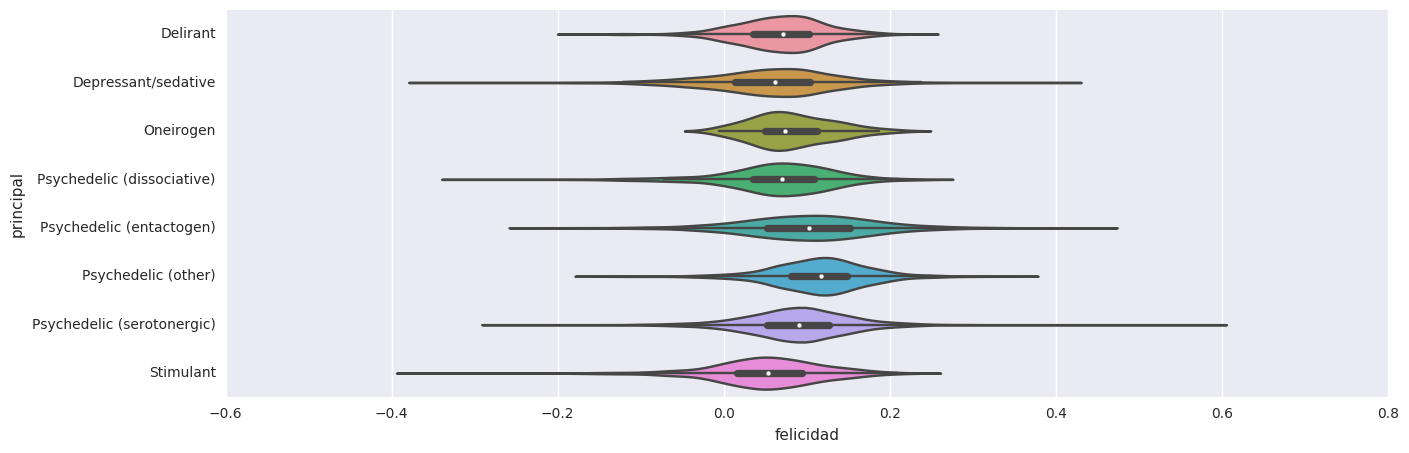

In [37]:
fig, ax = plt.subplots(figsize=(15,5))
sn.violinplot(x='felicidad', y='principal', data=df.groupby(['principal','experiencia']).felicidad.mean().to_frame().reset_index());

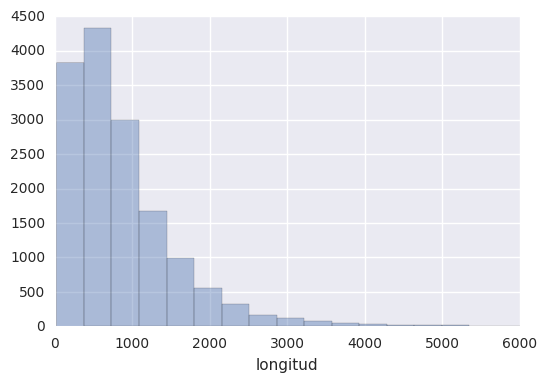

In [195]:
sn.distplot(erowid.longitud, kde=False)
plt.xlim(0,6000);

In [203]:
erowid_categorías.groupby('principal').longitud.median()

principal
Delirant                      689.0
Depressant/sedative           517.0
Psychedelic (dissociative)    657.5
Psychedelic (entactogen)      645.5
Psychedelic (other)           529.0
Psychedelic (serotonergic)    896.0
Stimulant                     516.0
Name: longitud, dtype: float64

### TODO

* filtrar palabras que no están en el diccionario
* quitar las palabras que refieren a drogas porque pueden estar sesgadas
* binarizar por símbolos
* ~~varianza, violinplot~~

27/04/18

Solo teniendo en cuenta palabras que están en el diccionario. No parece cambiar mucho...

In [117]:
for i, experiencia in ero.iterrows():
    felicidad_palabras = pd.Series([happiness.get(palabra) for palabra in experiencia.raices if happiness.get(palabra)])
    ero.at[i, 'felicidad_raices_dicc'] = felicidad_palabras
    ero.loc[i, 'felicidad_dicc'] = felicidad_palabras.mean()

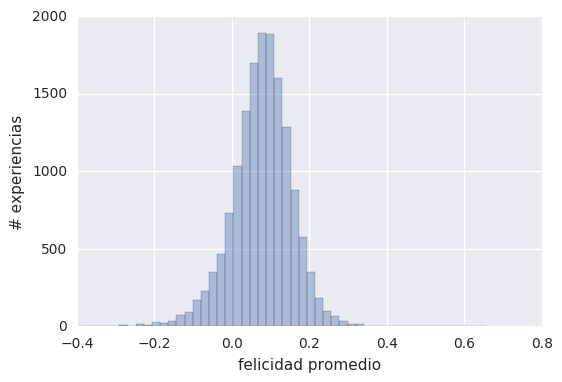

In [119]:
sn.distplot(ero.felicidad_dicc, kde=False)
plt.ylabel('# experiencias')
plt.xlabel('felicidad promedio');

Evolución de la felicidad. Esta vez no hay oraciones, solo tokens en secuencia.

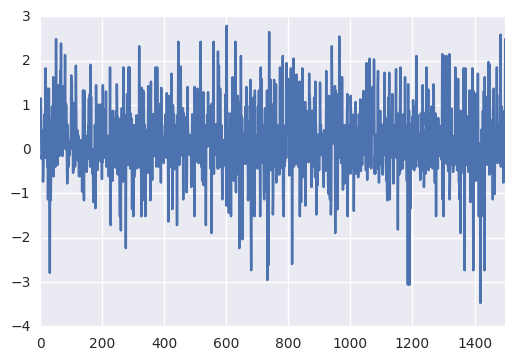

In [17]:
erowid.iloc[1100].felicidad_raíces.serie.plot();

Vemos que es una señal muy ruidosa, intentamos suavizarla.

In [18]:
def suavizado(felicidad_oración, alto=100, bajo=10):
    return felicidad_oración \
           .rolling(alto, center=True).mean() \
           .rolling(bajo, center=True).mean() \
           .dropna().reset_index(drop=True)

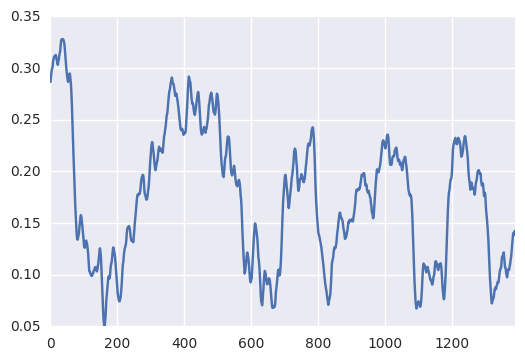

In [219]:
suavizado(erowid.iloc[1100].felicidad_raíces.serie).plot();

In [20]:
def subsample(felicidad_oración, longitud=400):
    return felicidad_oración[ sorted(np.random.choice( range( len(felicidad_oración) ), size=longitud, replace=False)) ] \
           .reset_index(drop=True)

In [221]:
def analizar_subsample(experiencia):
    felicidad_oración = suavizado(erowid.iloc[experiencia].felicidad_raíces.serie)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8,3))
    ax1.set_ylim(-0.6,0.6)
    
    felicidad_oración.plot(ax=ax1)
    subsample(felicidad_oración).plot(ax=ax2);

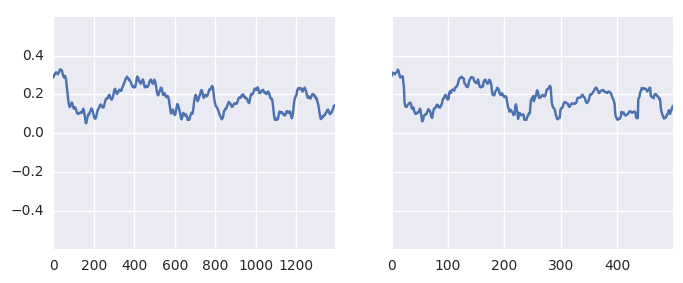

In [222]:
analizar_subsample(1100)

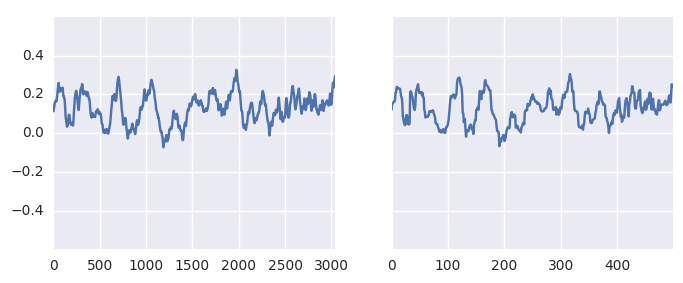

In [226]:
analizar_subsample(2200)

----



In [24]:
LONGITUD_MÍNIMA = 508

erowid_categorías_lm = erowid_categorías[erowid_categorías.longitud >= LONGITUD_MÍNIMA].copy()

In [34]:
for i, exp in erowid_categorías_lm.iterrows():
    erowid_categorías_lm.loc[i, 'felicidad_raíces_normalizada'] = Aseries(subsample(suavizado(exp.felicidad_raíces.serie)))

In [35]:
from sklearn.decomposition import TruncatedSVD

grupos = erowid_categorías_lm.groupby('principal')

In [53]:
svds = {}

for categoría, grupo in grupos:
    matriz = pd.DataFrame( { k:v.felicidad_raíces_normalizada.serie for k,v in grupo.iterrows() } )

    svds[categoría] = {}
    svds[categoría]['M'] = TruncatedSVD(n_components=9, n_iter=7, random_state=42)
    svds[categoría]['U'] = pd.DataFrame(svds[i]['M'].fit_transform(matriz))

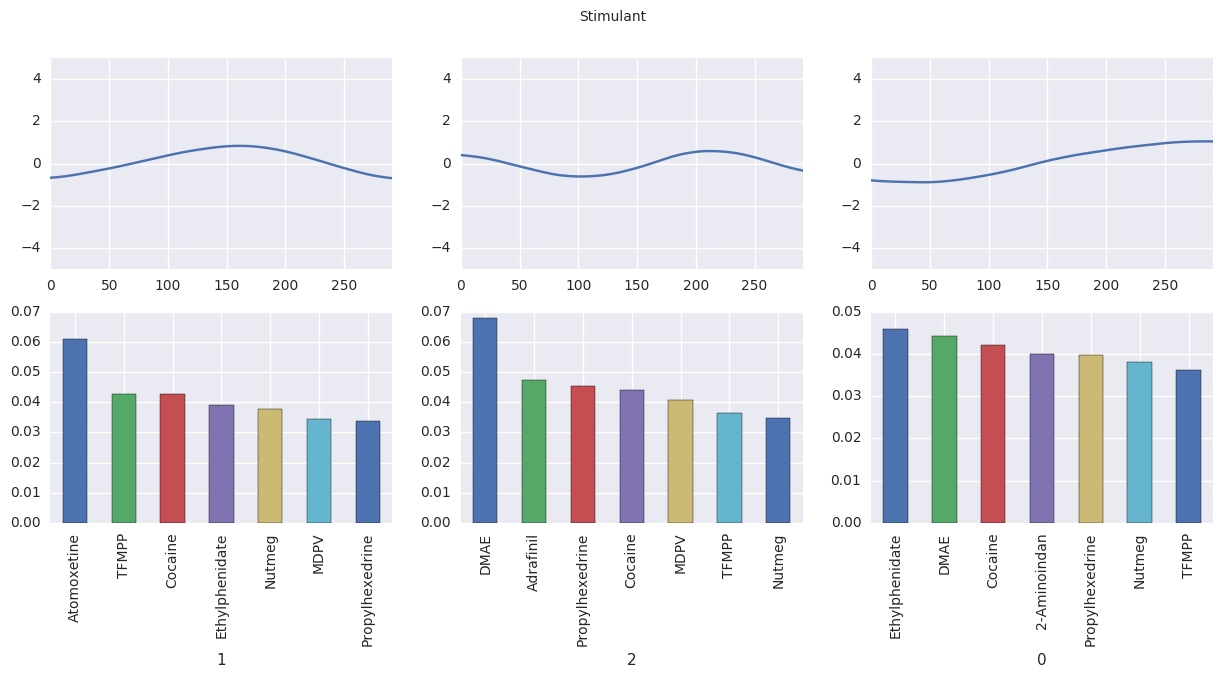

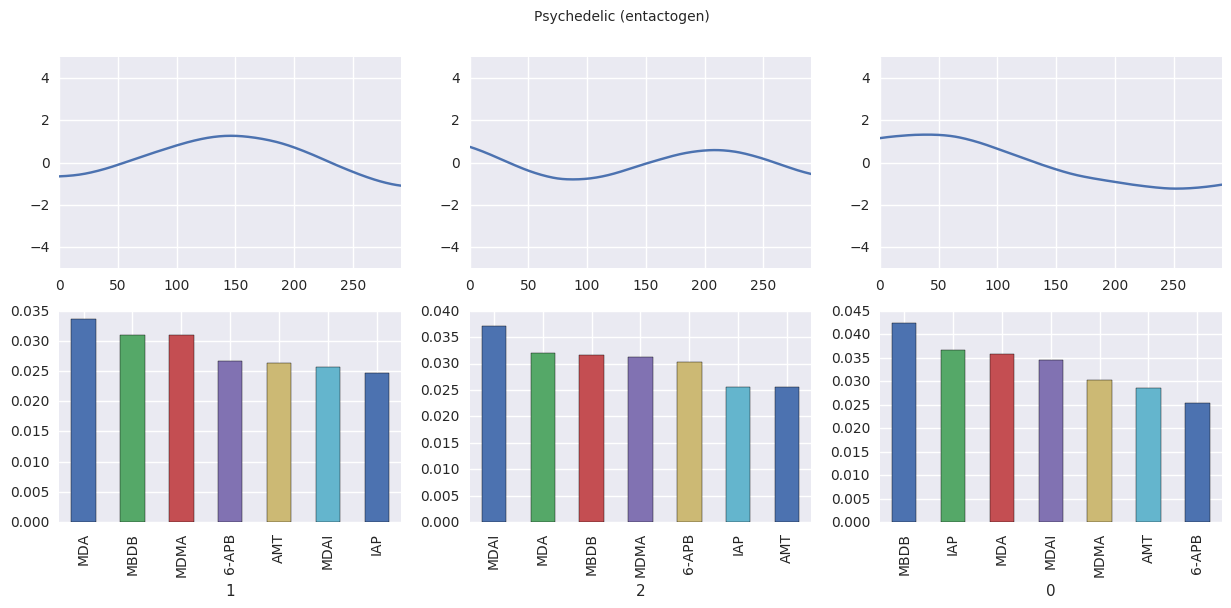

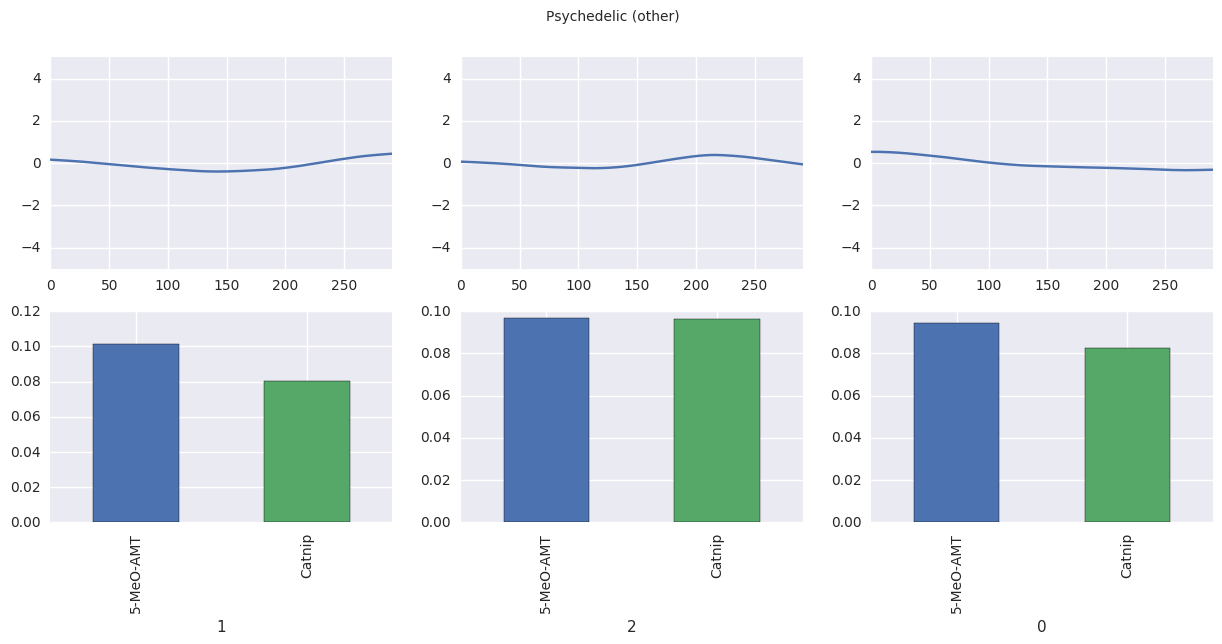

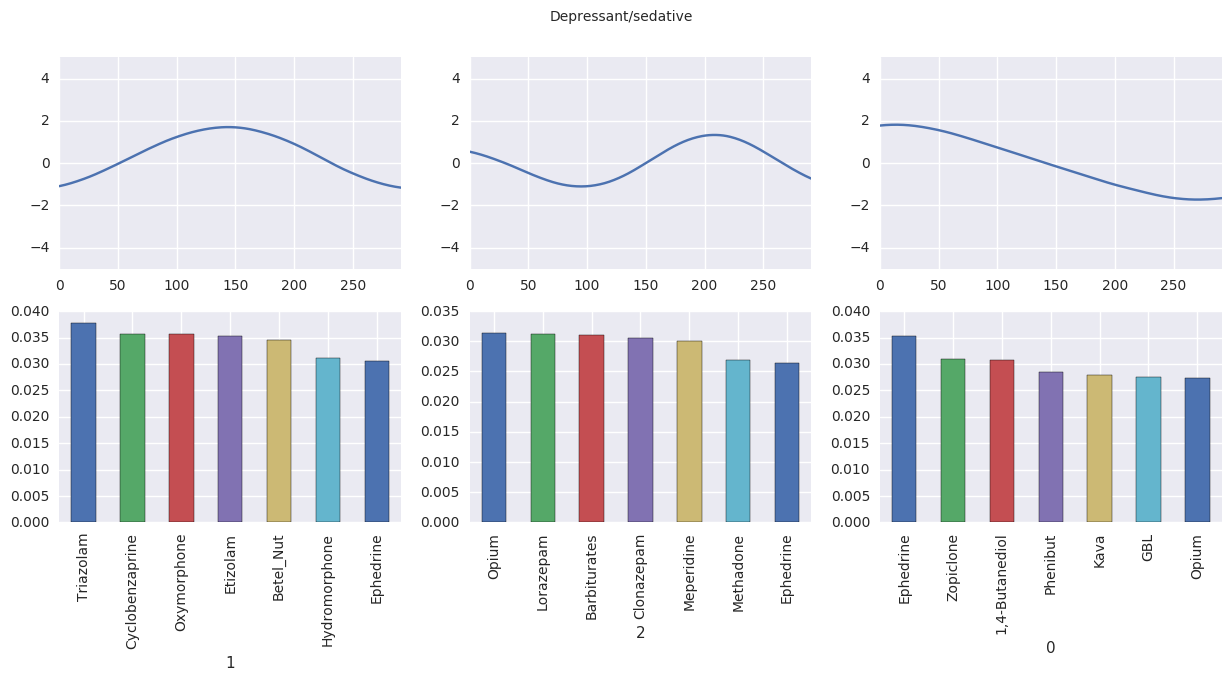

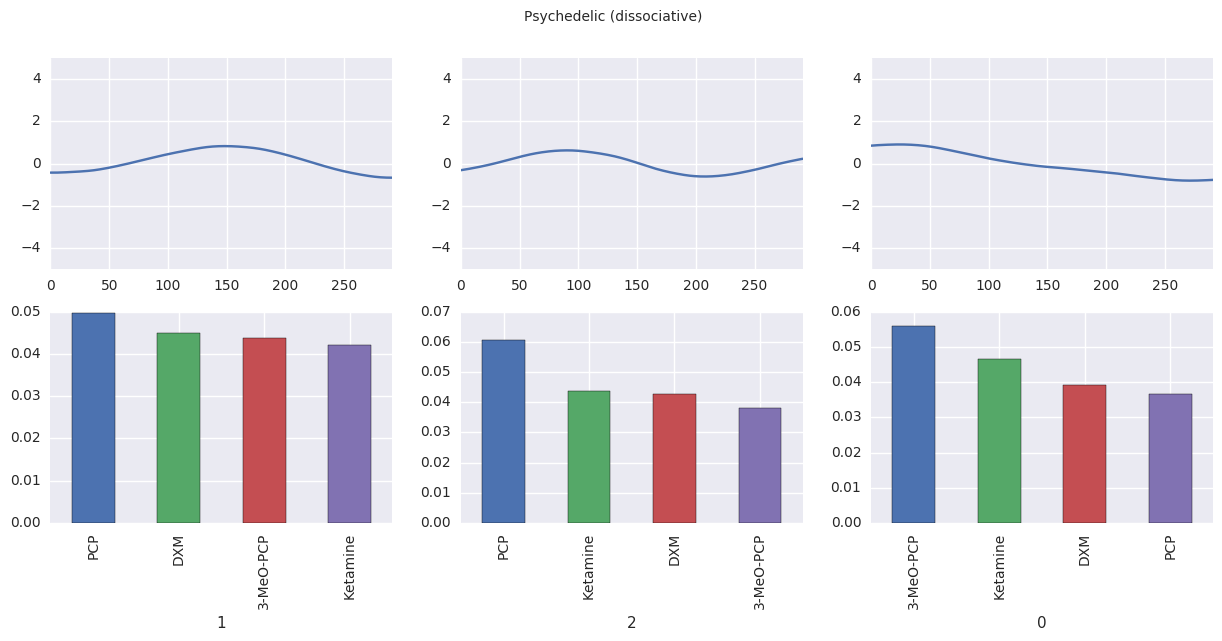

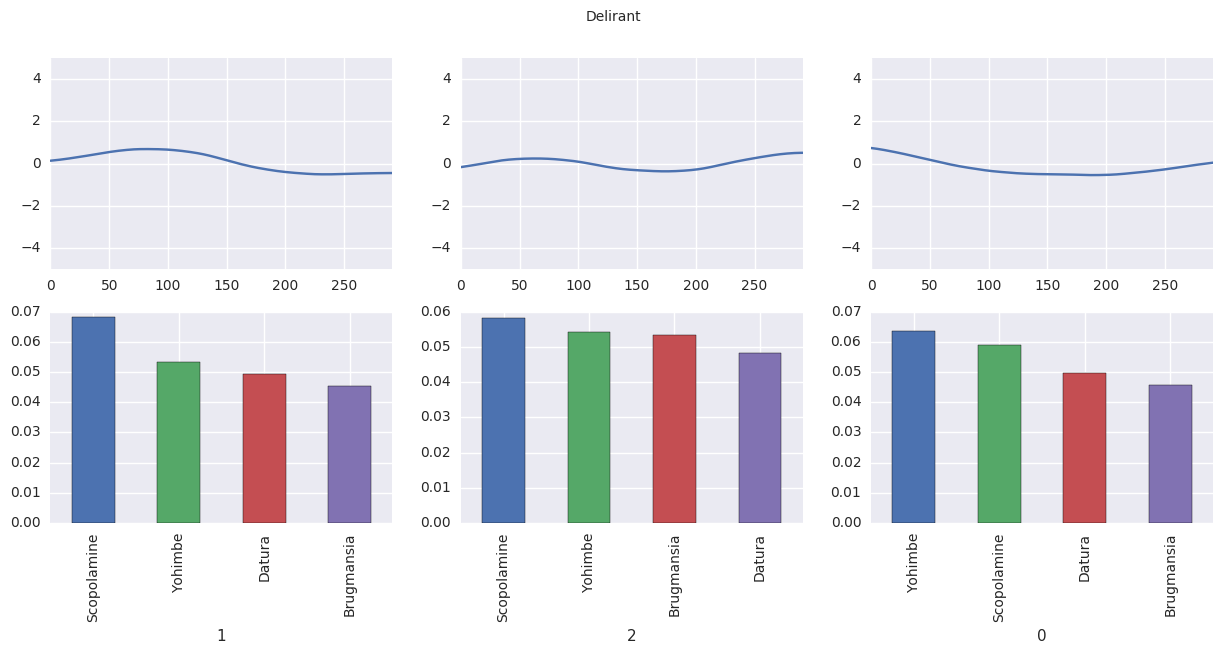

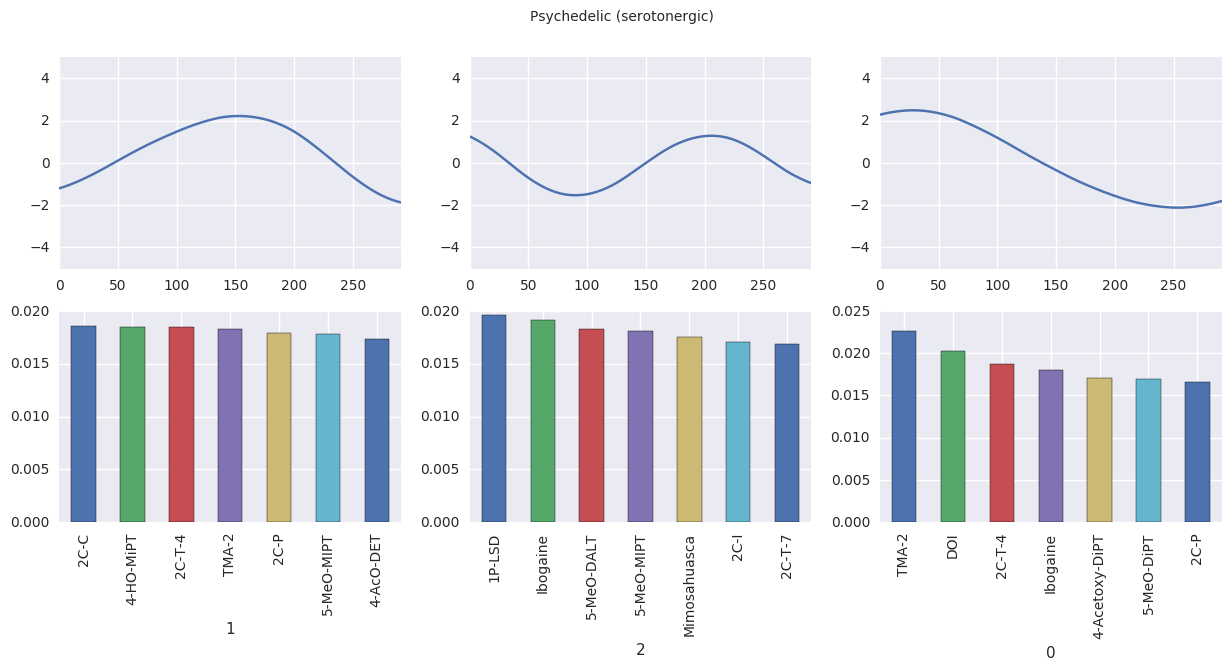

In [72]:
for categoría, svd in svds.items():
    fig, axes = plt.subplots(2,3, figsize=(15,6))
    fig.suptitle(categoría)
    
    grupo = grupos.get_group(categoría)
    
    
    paradigmas = svd['U'][[1,2,3]]

    for i, paradigma in enumerate(paradigmas):
        suavizado(paradigmas[paradigma]).plot(ylim=(-5,5), legend=False, ax=axes[0][i-1])
    
    
    componentes = svd['M'].components_[[1,2,3]]
    
    for i, curva in enumerate(componentes):

        m = pd.DataFrame(
            index=grupo.droga.values,
            data=abs(curva)
        ).reset_index()

        m.groupby('index')[0].mean().nlargest(7).plot(kind='bar', ax=axes[1][i-1])
        axes[1][i-1].set_xlabel(i)

### Sustancias por categoría

Cada cluster está formado por la misma cantidad de reportes, las contribuciones son diferentes. 

In [73]:
grupos.droga.count()

principal
Delirant                       247
Depressant/sedative           1338
Psychedelic (dissociative)     326
Psychedelic (entactogen)       688
Psychedelic (other)             71
Psychedelic (serotonergic)    2652
Stimulant                      398
Name: droga, dtype: int64

## Analizar ero

3 reportes con score alto (junto con el score promedio), 3 reportes con score promedio y 3 reportes con score bajo para delirantes y para alguna otra droga (diria entactogenos)

In [100]:
def analizar_experiencia(exp):
    suave = exp.felicidad_raíces.serie.round(2)
    
    a = []
    
    for w,v in zip(exp.raíces, suave):
        a.append( "{} ({})".format(w,v))
    
    return "  ".join(a)

In [141]:
N = 3

for categoría in ['Psychedelic (entactogen)', 'Delirant']:
    _categoría = erowid_categorías_lm[erowid_categorías_lm.principal == categoría]
    
    inferior, mediana, superior = _categoría.felicidad.quantile([0.48, 0.5, 0.52]).round(3)
    print(categoría, inferior, mediana, superior)
    
    # felicidad
    mucha = _categoría.nlargest(N, 'felicidad').index.values
    poca  = _categoría.nsmallest(N, 'felicidad').index.values
    
    promedio = _categoría[_categoría.felicidad.between(inferior,superior)].head(N).index.values

    for i, experiencia in enumerate(np.hstack([mucha, promedio, poca])):
        experiencia = erowid_categorías_lm.loc[experiencia]
        with open("{}_{}_{:+.3f}.txt".format(categoría, i+1, experiencia.felicidad), 'w') as archivo:
            archivo.write(analizar_experiencia(experiencia))

Psychedelic (entactogen) 0.109 0.111 0.113
Delirant 0.072 0.074 0.076


---

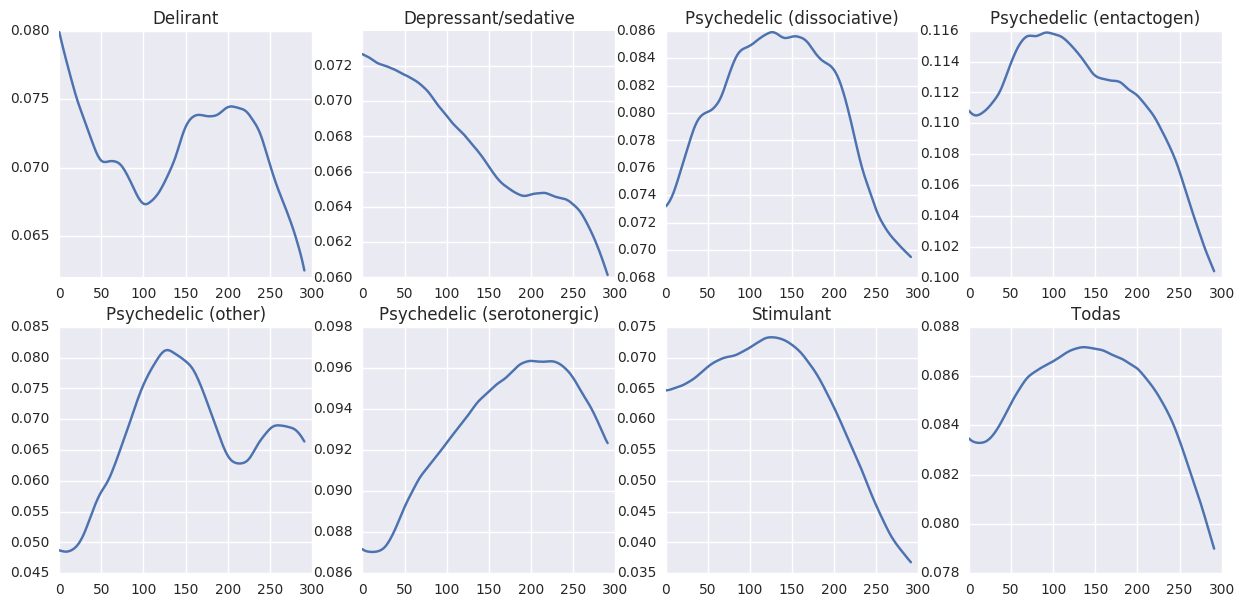

In [150]:
fig, axes = plt.subplots(2,4,figsize=(15,7))
axes = axes.flatten()

for i, (k,v) in enumerate(grupos.felicidad_raíces_normalizada):
    categoría = v.apply(lambda x: x.serie)
    #sn.tsplot(data=categoría.values, estimator=np.median, ax=axes[i])
    svds[k]['promedio'] = suavizado(categoría.mean(axis=0))
    ax = axes[i]
    ax.plot(svds[k]['promedio'])
    ax.set_title(k)
    
todas = erowid_categorías_lm.felicidad_raíces_normalizada.apply(lambda x: x.serie)
ax = axes[7]
ax.plot(suavizado(todas.mean(axis=0)))
ax.set_title('Todas');

In [191]:
from collections import Counter

SECCIONES = 5

for categoría, grupo in grupos:
    svds[categoría]['secciones'] = [Counter() for _ in range(SECCIONES)]
    
    for _, r in grupo.iterrows():
        
        for i, sección in enumerate(np.array_split(r.raíces, SECCIONES)):
            svds[categoría]['secciones'][i].update(sección)

In [190]:
for categoría, grupo in grupos:
    svds[categoría]['felicidad_secciones'] = np.zeros(SECCIONES)
    
    for _, r in grupo.iterrows():
        
        for i, sección in enumerate(np.array_split(r.felicidad_raíces.serie, SECCIONES)):
            svds[categoría]['felicidad_secciones'][i] += sección.mean() / len(grupo)

In [230]:
for categoría, grupo in grupos:
    svds[categoría]['palabras_secciones'] = []
    for sección in range(SECCIONES):
        f = svds[categoría]['felicidad_secciones'][sección]
        ff = [(palabra, cuenta, happiness.get(palabra, 0.0)) for palabra, cuenta in svds['Delirant']['secciones'][sección].items()]
        
        sup = f * 1.3
        inf = f * 0.7
        
        fff = [(palabra, cuenta, round(felicidad,3)) for palabra, cuenta, felicidad in ff if inf < felicidad < sup and cuenta > 9]
        
        svds[categoría]['palabras_secciones'].append(fff)

In [273]:
for categoría, grupo in grupos:

    acu = Counter()
    for contador in svds[categoría]['secciones']:
        acu = acu + contador
    
    svds[categoría]['todas_las_palabras'] = acu

In [274]:
for categoría, grupo in grupos:
    svds[categoría]['palabras_secciones_2'] = []
    
    for sección in range(SECCIONES):
        f = svds[categoría]['felicidad_secciones'][sección]
        ff = [(palabra, cuenta, happiness.get(palabra, 0.0)) for palabra, cuenta in svds[categoría]['todas_las_palabras'].items()]
        
        sup = f * 1.3
        inf = f * 0.7
        
        fff = [(palabra, cuenta, round(felicidad,3)) for palabra, cuenta, felicidad in ff if inf < felicidad < sup and cuenta > 9]
        
        svds[categoría]['palabras_secciones_2'].append(fff)

In [277]:
svds['Stimulant']['palabras_secciones_2'][4]

[('lick', 10, 0.025),
 ('one', 1112, 0.025),
 ('estimate', 21, 0.025),
 ('inside', 94, 0.025),
 ('absolute', 11, 0.025),
 ('main', 40, 0.025),
 ('tap', 11, 0.025),
 ('two', 565, 0.025),
 ('stomach', 122, 0.025),
 ('daily', 53, 0.025),
 ('each', 236, 0.025),
 ('document', 16, 0.025),
 ('earlier', 49, 0.025),
 ('lung', 28, 0.025),
 ('matter', 90, 0.025)]

### TODO

* filtrar palabras que no están en el diccionario
* quitar las palabras que refieren a drogas porque pueden estar sesgadas
* binarizar por símbolos
* ~~varianza, violinplot~~

07/05/18

**TODO**

1. por todas las drogas y por categoria de droga hacer un histograma de reportes y ver la cantidad de reportes que podes retener con una cantidad de oraciones dentro de un rango mas o menos acotado (inteyporlacion)

2. !!! enviarme las series de sentiment y las oraciones de los reportes de agentes delirantes (datura, brugmansia, etc) para entender si estamos asignando razonablemente el sentiment de algo que a priori deberia ser mas negativo de lo que es.

3. ~~eliminar del analisis la categoria antidepresivos/antipsicoticos~~

4. !!! Promediar todos los relatos dentro de cada categoria antes de hacer el clustering

5. Pensar un algoritmo de clustering que refleje la heterogeneidad o falta de heterogeneidad (redes donde el link esta pesado por la correlacion de la serie de tiempo del sentiment analysis y se aplican algoritmos de deteccion de comunas).

6. !!! Para cada cluster un histograma o pie chart que muestre las sustancias que estan representadas en cada clusters

7. !!! ~~Reportar cuantas sustancias hay por categoria y cluster~~

### TODO

* ~~Separar plots promediados~~
* ~~Quitar soporte, añadir sustancias en plots de componentes principales~~
* Normalizar componentes principales
* ~~Historias de delirantes~~

Interpretación de coeficientes negativos en la base de la transformación (SVD, LSI, LSA, PCA): https://www.quora.com/What-is-the-interpretation-of-negative-scores-in-the-basis-vectors-obtained-with-LSI

Lo mejor sería considerar los valores absolutos, ya que como la señal está compuesta por valores negativos tanto como positivos, un coeficiente negativo no podría interpretarse como ausencia.

**Normalización**

https://en.wikipedia.org/wiki/Generalized_singular_value_decomposition#Weighted_version

* clustering con y sin categorías
* palabras representativas del promedio (segmentadas por valor de emotividad y ventana temporal)
* considerar NNMF/LDA
* longitud downsampling por categoría
* redactar metodología

### TODO

* Cambiar gráficos de barras por wordclouds
* Resaltar escala de valores singulares
* Correr algoritmo SVD con diferentes inicializaciones para ver qué pasa con las componentes
* 

Corpus es una colección de reportes de uso de psicoactivos de erowid.org. Cada reporte está asociado a una substancia. Los reportes fueron preprocesados:

1. Tokenizados, tokens convertidos a minúsculas, signos de puntuación eliminados.
2. Lematizados, tokens llevados a lemas según WordNet.

Posteriormente se convirtió a cada palabra a un valor de felicidad. Estos valores están dados por un diccionario de 10.000 palabras comunes. Las palabras fueron valuadas al promediar la valuación de 50 personas aplicando una escala del 1 (poco feliz) al 9 (muy feliz). Al diccionario se le resta el promedio general de todas las palabras, pasando a una escala que aproximadamente va de -4,5 a 4,5.

La felicidad de una experiencia es el promedio de la felicidad de sus palabras. Las experiencias están agrupadas en categorías más generales, seǵun las substancias en las cuales están basadas. La felicidad de una categoría es el promedio de la felicidad de sus experiencias.

Las evolución de la felicidad de una experiencia es la felicidad de las palabras en función de la posición de las palabras en el texto. Por lo general las evoluciones son ruidosas al no haber una conexión del sentido y la emotividad entre palabras—cada palabra es valuada independientemente de las demás. Se aplica un suavizado que consiste en:

1. *Moving average* centrado de 100 palabras (pasa alto).
2. *Moving average* centrado de 10 palabras (pasa bajo).